In [55]:
import numpy as np
import requests
import json
from collections import namedtuple
import os
import sys
import matplotlib.pyplot as plt
from matplotlib.image import imread

import tqdm
import torch
import torchvision.transforms as transforms
from torchvision.datasets import EMNIST, MNIST
from tqdm.notebook import tqdm, trange
from torch.optim.lr_scheduler import StepLR

! pip install torchsummary 
from torchsummary import summary

In [56]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [57]:

from art.utils import load_mnist

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # mps does not work


In [58]:

# Model 
class Net(nn.Module):
    def __init__(self, n_classes):
        super(Net, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=1)
        self.conv_2 = nn.Conv2d(in_channels=4, out_channels=10, kernel_size=5, stride=1)
        self.fc_1 = nn.Linear(in_features=4 * 4 * 10, out_features=100)
        self.fc_2 = nn.Linear(in_features=100, out_features=n_classes)

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.reshape(-1, 4 * 4 * 10)
        #x = x.view(-1, 4 * 4 * 10)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x


def _create_model(model_name, n_classes):
    model = Net(n_classes)
    
    return model



def data_processing_mnist(classes=None, device=device):
    (x_train, y_train), (x_test, y_test), min_, max_ = load_mnist()

    mean = np.mean(x_train,axis=(0,1,2,3))
    std = np.std(x_train,axis=(0,1,2,3))
    x_train = (x_train-mean)/(std+1e-7)
    x_test = (x_test-mean)/(std+1e-7)

    x_train = np.transpose(x_train, [0, 3,1,2])
    x_test = np.transpose(x_test, [0, 3,1,2])

    min_ = (min_-mean)/(std+1e-7)
    max_ = (max_-mean)/(std+1e-7)


    y_train = np.argmax(y_train, axis=1)
    y_test = np.argmax(y_test, axis=1)
    if classes is not None:
        idx_tr = np.argwhere([y in classes for y in y_train]).ravel()
        idx_te = np.argwhere([y in classes for y in y_test]).ravel()
        
        x_train = x_train[idx_tr]
        y_train = y_train[idx_tr]

        x_test = x_test[idx_te]
        y_test = y_test[idx_te]

        new_y_train = []
        new_y_test = []
        for i,y in enumerate(y_train):
                new_y_train.append(classes.index(y))
        for i,y in enumerate(y_test):
                new_y_test.append(classes.index(y))

        y_train = np.array(new_y_train)
        y_test = np.array(new_y_test)

   
    x_tensor = torch.tensor(x_train, dtype=torch.float32, device=device) # transform to torch tensor
    x_tensor_test = torch.tensor(x_test, dtype=torch.float32, device=device) # transform to torch tensor
    
    y_tensor = torch.tensor(y_train, dtype=torch.long, device=device)

    y_tensor_test = torch.tensor(y_test, dtype=torch.long, device=device)

    return x_tensor, y_tensor, x_tensor_test, y_tensor_test


In [59]:
# TO GET THE MODEL RUNNING:

MODEL_NAME = "mnist_4_dc30"

n_classes = 4
model = _create_model(MODEL_NAME, n_classes)

model_checkpoint_path = './extract_target_%s_mnist.pt' % MODEL_NAME
if os.path.isfile(model_checkpoint_path):
    checkpoint = torch.load(model_checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print('loaded model checkpoint')
else:
    raise FileNotFoundError("Checkpoint file not found, check your path.")

x_train, y_train, x_test, y_test = data_processing_mnist()

# Test
prediction = model(x_test)

loaded model checkpoint


In [107]:
import matplotlib.pyplot as plt
def plot_images(tensors):
    """ Plot normalised MNIST images """
    fig = plt.figure(figsize=(10, 5))

    n_tensors = len(tensors)
    n_cols = n_tensors
    n_rows = 1

    for row in range(n_rows):
        for col in range(n_cols):
            idx = n_cols * row + col

            if idx > n_tensors - 1:
                break

            ax = fig.add_subplot(n_rows, n_cols, idx + 1)
            tensor = tensors[idx]

            # Clip image values
            tensor[tensor < 0] = 0
            tensor[tensor > 1] = 1

            # Put the channel last
            tensor = torch.permute(tensor, (1, 2, 0))

            ax.imshow(tensor)

    plt.tight_layout()
    plt.show()

In [108]:
def attack(attack_model):
    """ For the 6 output classes of the model, get its reconstructed train data sample """
    images = []

    for idx in range(6):
        target_output = np.zeros(6)
        target_output[idx] = 1

        with torch.no_grad():
            reconstructed_image = attack_model(torch.tensor([target_output]).float()).squeeze(0)

        images.append(reconstructed_image.cpu())

    plot_images(images)

In [171]:
from torchvision.datasets import MNIST, EMNIST
from torchvision import transforms
import torch
from torch.utils.data import Dataset

x_train, y_train, x_test, y_test = data_processing_mnist()



class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

attacker_dataset_train = CustomDataset(x_train, y_train)
attacker_dataset_test = CustomDataset(x_test, y_test)

In [172]:
# Dataloader
attacker_loader_train = torch.utils.data.DataLoader(attacker_dataset_train, batch_size=64)
attacker_loader_test = torch.utils.data.DataLoader(attacker_dataset_test, batch_size=64)

In [173]:
def plot_images(tensors):
    """ Plot normalised MNIST images """
    fig = plt.figure(figsize=(10, 5))

    n_tensors = len(tensors)
    n_cols = n_tensors
    n_rows = 1

    for row in range(n_rows):
        for col in range(n_cols):
            idx = n_cols * row + col

            if idx > n_tensors - 1:
                break

            ax = fig.add_subplot(n_rows, n_cols, idx + 1)
            tensor = tensors[idx]

            # Clip image values
            tensor[tensor < 0] = 0
            tensor[tensor > 1] = 1

            # Put the channel last
            tensor = torch.permute(tensor, (1, 2, 0))

            ax.imshow(tensor)

    plt.tight_layout()
    plt.show()

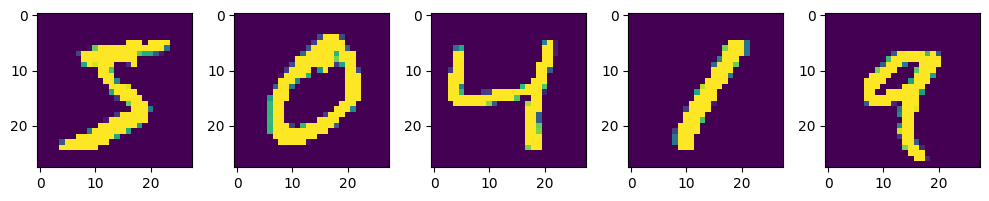

In [174]:
def plot_data(data_loader):
    """ Plot data used to supposedly train the target model """
    images = []

    for _, (data, _) in enumerate(data_loader):
        for i in range(5):
            images.append(data[i])

        break

    plot_images(images)

plot_data(attacker_loader_train)

In [175]:
## Target model
class TargetModel(torch.nn.Module):
    def forward(self, x):

        # Put the channel last
        #x = torch.permute(x, (0, 2, 3, 1))

        # Query the Target Model to get a confidence score
        #try:
        output = model(x)
            #response = requests.post("https://inference.fly.dev/score", data = json.dumps({"input": x.tolist()}))
            #res = json.loads(response.text)
        #except requests.exceptions.ConnectionError:
            #print("Connection problems. Contact the CTF organizers.")

        return np.array(output)#np.array(res['outputs'])

# Get target
target_model = TargetModel()

In [176]:
def get_target_labels(loader):
    """ Gather data labels from the target model """
    attacker_targets = []

    for data, label in tqdm(loader):
        data.float()

        with torch.no_grad():
            attacker_targets.append(target_model(data))

    return torch.tensor(np.concatenate(attacker_targets))

attacker_targets_train = get_target_labels(attacker_loader_train)
attacker_targets_test = get_target_labels(attacker_loader_test)

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

In [177]:
def reconstruct_samples(model):
    """ Visualize the model's capacity to reconstruct the original image based on the Target model output """
    images = []

    for batch, (data, _) in enumerate(attacker_loader_train):
        # Take the model output intercepted from the target model
        # For train data
        targets = attacker_targets_train[
            batch*attacker_hyperparams.batch_size:
            (batch+1)*attacker_hyperparams.batch_size
            ].float()

        for i in range(2):

            with torch.no_grad():
                reconstructed_image = model(torch.unsqueeze(targets[i], 0)).squeeze(0)

            images.append(data[i])
            images.append(reconstructed_image.cpu())
        break

    for batch, (data, _) in enumerate(attacker_loader_test):
        # Take the model output intercepted from the target model
        # For test data
        targets = attacker_targets_test[
            batch*attacker_hyperparams.batch_size:
            (batch+1)*attacker_hyperparams.batch_size
            ].float()

        for i in range(2):

            with torch.no_grad():
                reconstructed_image = model(torch.unsqueeze(targets[i], 0)).squeeze(0)

            images.append(data[i])
            images.append(reconstructed_image.cpu())
        break

    plot_images(images)

In [181]:
class AttackModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = torch.nn.Sequential(
            torch.nn.Linear(4, 14*14*4),
            torch.nn.ReLU(),
            torch.nn.Unflatten(1, (4, 14, 14)),
            torch.nn.ConvTranspose2d(
                in_channels=4,
                out_channels=1,
                kernel_size=3,
                padding=1,
                stride=2,
                output_padding=1),
        )

    def forward(self, x):
        return self.layers(x)

# Get attacker
attacker = AttackModel()
summary(attacker, (4, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 784]           3,920
              ReLU-2                  [-1, 784]               0
         Unflatten-3            [-1, 4, 14, 14]               0
   ConvTranspose2d-4            [-1, 1, 28, 28]              37
Total params: 3,957
Trainable params: 3,957
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.02
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [182]:
def attack(attack_model):
    """ For the 6 output classes of the model, get its reconstructed train data sample """
    images = []

    for idx in range(4):
        target_output = np.zeros(4)
        target_output[idx] = 1

        with torch.no_grad():
            reconstructed_image = attack_model(torch.tensor([target_output]).float()).squeeze(0)

        images.append(reconstructed_image.cpu())

    plot_images(images)

  0%|          | 0/100 [00:00<?, ?it/s]

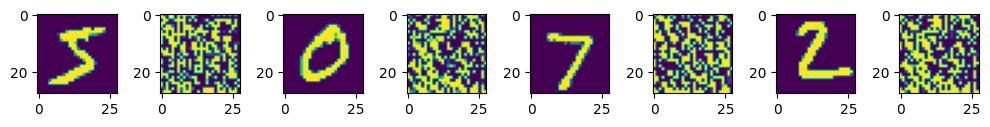

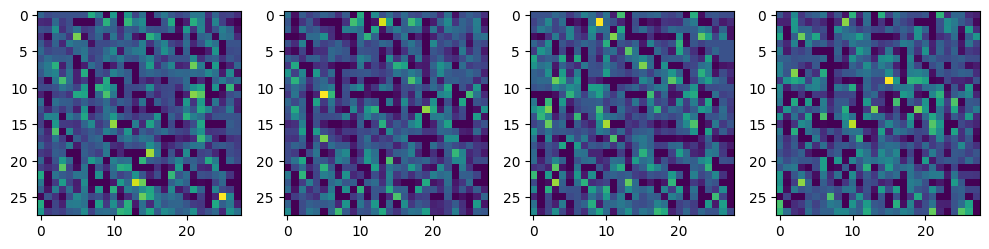

0 2.338701627635956
1 0.7156158135414123
2 0.654700364780426
3 0.6439597138722738
4 0.6423006181399028
5 0.6455799626032511
6 0.6469631256739299
7 0.6509793235778809
8 0.653611369228363
9 0.6579693564097087
10 0.6620970567703247
11 0.6659262632687887
12 0.6665687365849813
13 0.6725944489161173
14 0.6740500545183817
15 0.6775988151868184
16 0.6788203934351603
17 0.6783274789810181
18 0.6797964577992757
19 0.6815316652297974


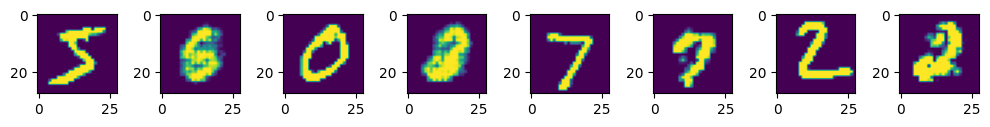

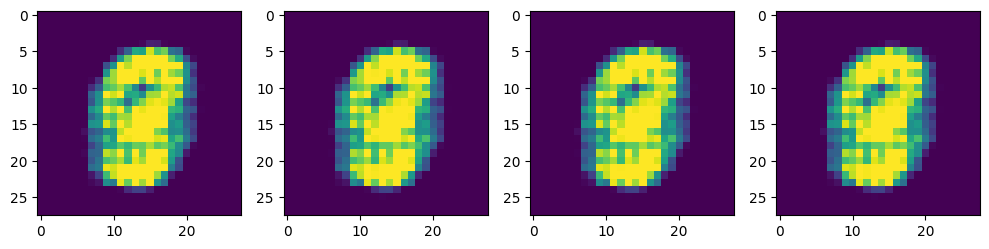

20 0.6807827218691508
21 0.6816685149510702
22 0.6807986911137899
23 0.6812561031023662
24 0.6805137253761292
25 0.6825496540705362
26 0.6841051488876343
27 0.6828033998171489
28 0.6839487588246663
29 0.6834433448473612
30 0.6320918590545654
31 0.6266168518066406
32 0.6251608330408732
33 0.6245920634587606
34 0.6242270124753316
35 0.6237116499265035
36 0.6229158343633016
37 0.6222764719963074
38 0.6218697348594665
39 0.6213605477333068


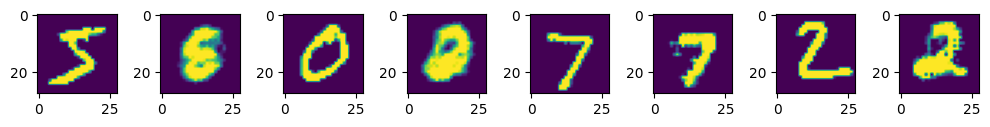

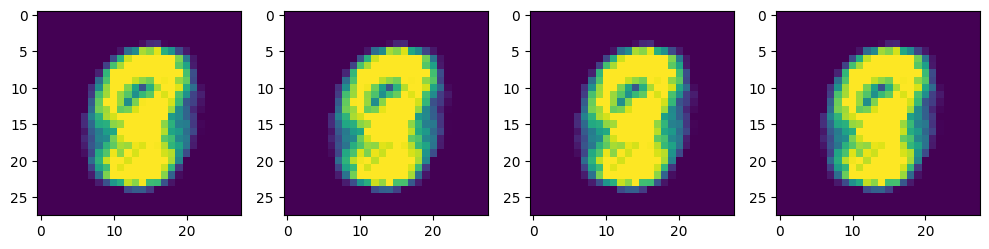

40 0.6205151429494222
41 0.6200457444190979
42 0.6196504309654236
43 0.6192248220125834
44 0.6188745799382528
45 0.6186234487215678
46 0.6183641869227091
47 0.6179025615056356
48 0.6176749915122985
49 0.6175143212000529
50 0.617286363919576
51 0.6170975015640259
52 0.6168258525530497
53 0.616653650824229
54 0.6165084290186564
55 0.6163592726389567
56 0.6162423123677572
57 0.6161126861254375
58 0.6159853375116984
59 0.6159145102183025


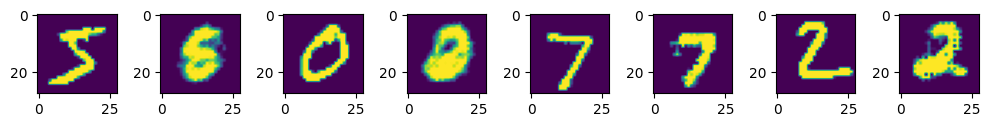

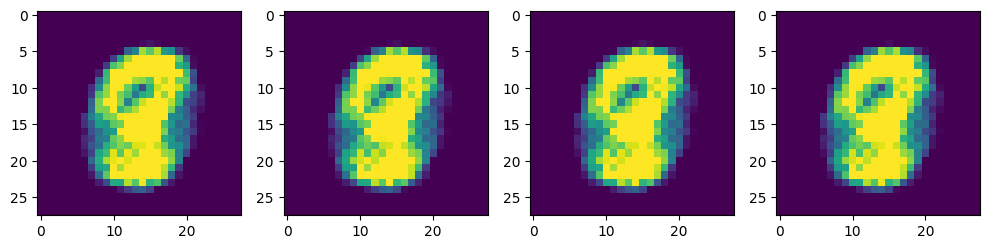

60 0.6083887895584107
61 0.6075629212061564
62 0.6074639212290446
63 0.6073952864964803
64 0.6073279777208964
65 0.6072592037200928
66 0.6071917623837789
67 0.6071275437355041
68 0.6070648359934488
69 0.6070068218231202
70 0.6069482429186503
71 0.6068843779563904
72 0.6068228933334351
73 0.6067682766278585
74 0.6067181281089783
75 0.6066708219528198
76 0.6066246347427369
77 0.6065772795041402
78 0.6065299044926962
79 0.6064810669263204


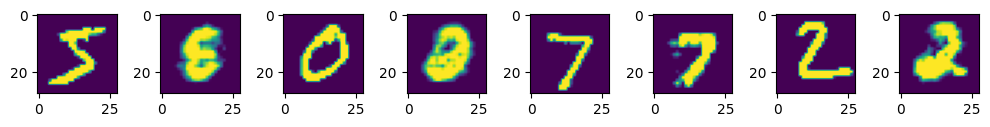

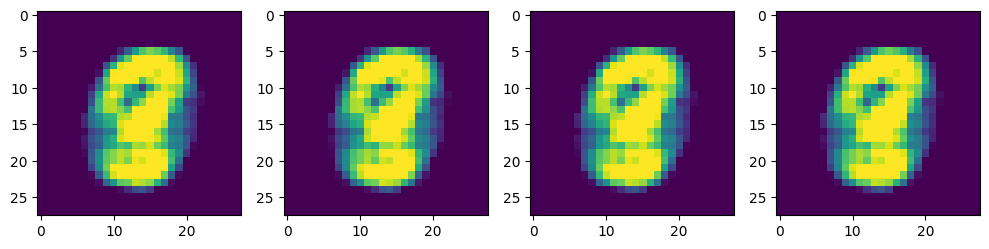

80 0.6064365356445313
81 0.6063968850453695
82 0.6063589273452759
83 0.6063229887008666
84 0.6062884755134582
85 0.6062546069463094
86 0.6062222032546997
87 0.6061903659184774
88 0.6061588722229004
89 0.6061285150527954
90 0.604920976638794
91 0.6046974613507589
92 0.6046786150296529
93 0.6046708118438721
94 0.6046651724179586
95 0.6046599142392476
96 0.6046548334439595
97 0.6046497721036275
98 0.6046446421305338
99 0.6046394659678141
Finished Training


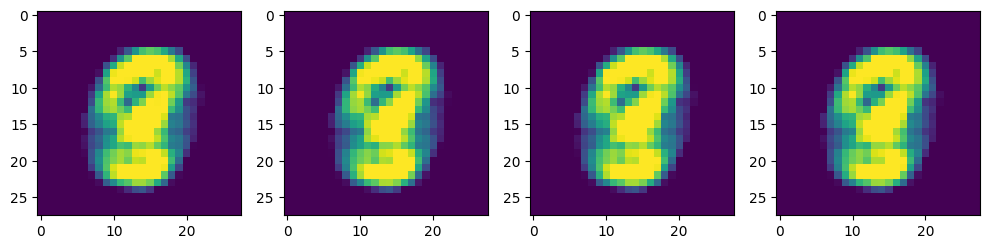

In [183]:
torch.manual_seed(0)

# Train on the entire dataset
attacker = AttackModel()

hyperparams = namedtuple('hyperparams', 'batch_size,epochs,learning_rate')

attacker_hyperparams = hyperparams(
    batch_size=128,
    epochs=100,
    learning_rate=5e-2,
)

# Dataloader
attacker_loader_train = torch.utils.data.DataLoader(attacker_dataset_train, batch_size=attacker_hyperparams.batch_size)

# Optimizer
attack_optim = torch.optim.Adam(attacker.parameters(), lr=attacker_hyperparams.learning_rate)

# Learning Rate Schedule
scheduler = StepLR(attack_optim, step_size=30, gamma=0.1, verbose=False)

for epoch in trange(attacker_hyperparams.epochs):
    epoch_loss = 0.0

    for batch, (data, targets) in enumerate(attacker_loader_train):
        if not (epoch % 20) and not batch:
            ## Generated images
            reconstruct_samples(attacker)
            attack(attacker)

        data.float()
        # Take the model output intercepted from the target model
        targets = attacker_targets_train[
            batch*attacker_hyperparams.batch_size:
            (batch+1)*attacker_hyperparams.batch_size
            ].float()

        attack_optim.zero_grad()

        # Reconstruct image
        output = attacker(targets)

        # Compute loss & Backprop
        loss = ((output - data)**2).mean() # We want our reconstructed image to look as much like the original image as possible
        loss.backward()
        attack_optim.step()

        # Logging/Display training progression
        ## Loss
        epoch_loss += output.shape[0] * loss.item()

    print(epoch, epoch_loss / len(attacker_dataset_train))
    scheduler.step()

print('Finished Training')
attack(attacker)
